Задача на три распития кофе:
1. Прочитать имеющиеся датасеты, привести к общему виду
2. Написать сетку
3. Обучить сетку
4. ???
5. Вы восхитительны!

### Предобработка разметок
Датасеты:
* 0000-0029 норм
* 0100-0130 ?
* 0170-0205 плох
* 0301-0335 норм
* 0599-0629 норм
* 2228-2257 норм
* 2800-2835 ???
* 2970-2999 норм

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import os
import pandas as pd

datasetsPath = '/content/drive/MyDrive/Colab Notebooks/Spinal/datasets/'
os.chdir(datasetsPath)
datasetsList = os.listdir()
# Заглушка от неподходящих датасетов:
# datasetsList.remove('2800-2835.json')
print(datasetsList)

['2970-2999.json', '02800-02835.csv', '100-130_301-335_950-980.csv', '0950-0980.json', '2800-2835.json', '2228-2257.json', '0599-0629.json', '0301-0335.json', '0100-0130.json', '0100-0130.csv', '0000-0029.json', '0170-0205.json']


In [ ]:
imagesPath = '/content/drive/MyDrive/Colab Notebooks/Spinal/images/'
print(os.listdir(imagesPath))

['02695.PNG', '02692.PNG', '02686.PNG', '02739.PNG', '02698.PNG', '02745.PNG', '02702.PNG', '02741.PNG', '02711.PNG', '02718.PNG', '02750.PNG', '02691.PNG', '02727.PNG', '02725.PNG', '02682.PNG', '02728.PNG', '02719.PNG', '02717.PNG', '02731.PNG', '02703.PNG', '02736.PNG', '02730.PNG', '02716.PNG', '02733.PNG', '02706.PNG', '02687.PNG', '02749.PNG', '02723.PNG', '02793.PNG', '02816.PNG', '02812.PNG', '02824.PNG', '02817.PNG', '02811.PNG', '02805.PNG', '02785.PNG', '02780.PNG', '02756.PNG', '02764.PNG', '02763.PNG', '02754.PNG', '02821.PNG', '02791.PNG', '02798.PNG', '02783.PNG', '02806.PNG', '02768.PNG', '02753.PNG', '02776.PNG', '02755.PNG', '02752.PNG', '02786.PNG', '02787.PNG', '02809.PNG', '02788.PNG', '02800.PNG', '02813.PNG', '02766.PNG', '02814.PNG', '02771.PNG', '02803.PNG', '02767.PNG', '02770.PNG', '02799.PNG', '02815.PNG', '02779.PNG', '02778.PNG', '02819.PNG', '02794.PNG', '02792.PNG', '02797.PNG', '02808.PNG', '02775.PNG', '02789.PNG', '02781.PNG', '02758.PNG', '02765.PNG'

In [ ]:
# Removing extraneous rows
def read_data(path: str, truncated: bool = False):
    df = pd.read_json(path)
    if truncated:
        df = df.transpose()
        df = df.drop('file_attributes', axis=1)
    else:
        df = pd.json_normalize(df['_via_img_metadata'])
    df = df[~df['regions'].isna()]
    df = df.loc[df['regions'].map(len) > 0]
    df = df.set_index('filename')
    return df

# Combining all datasets into a single one
df = pd.DataFrame()
for dataset in datasetsList:
  if 'json' in dataset:
    datasetPath = f'{datasetsPath}{dataset}'
    if any(x in dataset for x in ['100', '950', '2800']):
      truncFlag = True
    else:
      truncFlag = False
    df = pd.concat([df, read_data(datasetPath, truncFlag)])
print(f'Total images:{len(df.regions.index)}')

Total images:290


In [ ]:
# Checking whether a region is a vertebra or a disc
def checkVertebra(region):
    region_attributes = region['region_attributes']
    if ('vertebra' in region_attributes and region_attributes['vertebra'] == '1' or
       'spinal canal' in region_attributes and region_attributes['spinal canal'] == '2' or
       'Bone' in region_attributes and region_attributes['Bone'] == '4' or
       'Spine' in region_attributes and region_attributes['Spine'] == '1' or
       'verteba' in region_attributes and '1' in region_attributes['verteba'] or
       'vertebral_body' in region_attributes and '1' in region_attributes['vertebral_body'] or
       'spinal_canal' in region_attributes and region_attributes['spinal_canal'] == '2' or
       'bone' in region_attributes and region_attributes['bone'] == '1' or
       'spine' in region_attributes and region_attributes['spine'] == '1' or
       'кость'  in region_attributes and region_attributes['кость'] == '1'):
        return True
    else:
       return False

def checkDisc(region):
    region_attributes = region['region_attributes']
    if ('Normal disk' in region_attributes and region_attributes['Normal disk'] == '1' or
       'intervertebral disc' in region_attributes and region_attributes['intervertebral disc'] == '0' or
       'intervertebral disc' in region_attributes and region_attributes['intervertebral disc'] == '1' or
       'spine disc' in region_attributes and region_attributes['spine disc'] == '2' or
       'spine disc' in region_attributes and '2' in region_attributes['spine disc'] or
       'invertebral_disk' in region_attributes and region_attributes['invertebral_disk'] == '1' or
       'spinal disc' in region_attributes and region_attributes['spinal disc'] == '1' or
       'intervertebral disc' in region_attributes and region_attributes['intervertebral disc'] == '2' or
       'intervertebral_disc' in region_attributes and region_attributes['intervertebral_disc'] == '2'):
        return True
    else:
       return False

In [ ]:
count = 0
countVert = 0
countDisc = 0
for image in df.regions.index:
  count += len(df.loc[image].regions)
  for region in df.loc[image].regions:
    if checkVertebra(region): countVert += 1
    if checkDisc(region): countDisc += 1
  #for i in range(len(df.loc[image]].regions)+1):
print(f'Total regions marked: {count}. Total vertebrae: {countVert}. Total discs: {countDisc}. Unaccounted: {count - countVert - countDisc}')

Total regions marked: 4235. Total vertebrae: 1888. Total discs: 1751. Unaccounted: 596


Судя по тому, что сумма не сходится, где-то что-то потерял (помимо того датасета, где размечено четыре параметра).



In [ ]:
# обработка и рисование изображений
from PIL import Image, ImageDraw

# рисование графиков
import matplotlib.pyplot as plt

import numpy as np # для работы с массивами

# для создание модели
import tensorflow as tf
# Слои, которые потребуются
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose # транспонированная свертка
from keras.layers import concatenate # объединение тензоров

from keras.losses import binary_crossentropy # функция ошибки
from sklearn.model_selection import train_test_split # разделение данных на обучающее и проверочное множества

### Создание масок

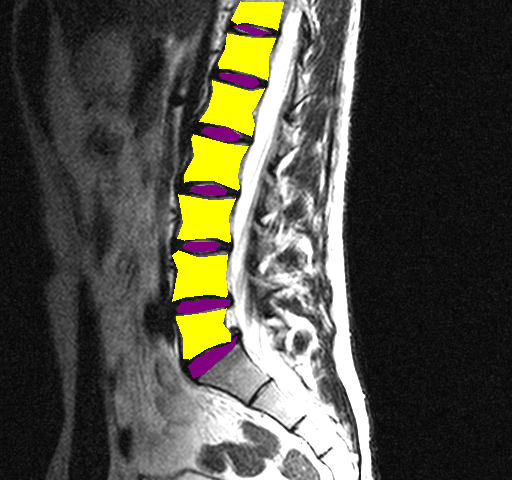

In [ ]:
maskedPath = '/content/drive/MyDrive/Colab Notebooks/Spinal/masked/'
#Function for drawing the mask for discs and vertebrae
def drawMask(image_name, image_regions, preview = False):
    image = Image.open(f'{imagesPath}{image_name}').convert('RGB')
    if preview:
      image_draw = ImageDraw.Draw(image)
      color1 = 'yellow'
      color2 = 'purple'
      color3 = 'blue'
    else:
      mask = Image.new(mode='L', size=image.size)
      mask_draw = ImageDraw.Draw(mask)
      color1 = 1
      color2 = 2
      color3 = 0

    for region in image_regions:
        shape_attribites = region['shape_attributes']
        points = list(zip(shape_attribites['all_points_x'], shape_attribites['all_points_y']))
        if checkVertebra(region):
          color = color1
        elif checkDisc(region):
          color = color2
        else:
          if preview:
            color = color3
          else:
            continue

        if preview:
          image_draw.polygon(points, fill=color)
        else:
          mask_draw.polygon(points, fill=color)

    if preview:
      image.show()
    else:
      mask.convert('L').save(maskedPath + image_name)

#drawMask('00003.PNG', df.loc['00003.PNG'].regions, True)
drawMask('00100.PNG', df.loc['00100.PNG'].regions, True)
#drawMask('00301.PNG', df.loc['00301.PNG'].regions, True)
#drawMask('02800.PNG', df.loc['02800.PNG'].regions, True)
#drawMask('02970.PNG', df.loc['02970.PNG'].regions, True)
#drawMask('00100.PNG', df.loc['00100.PNG'].regions)

# Generating masks for all the images in the dataset
#for row in df.itertuples():
  #os.system(f'rm -i {maskedPath}')
  #drawMask(row.Index, row.regions)

In [ ]:
# Saving all images in the dataset in the special folder for further use
unmaskedPath = '/content/drive/MyDrive/Colab Notebooks/Spinal/unmasked/'

import shutil
for image in df.regions.index:
  shutil.copy2(f'{imagesPath}{image}', f'{unmaskedPath}{image}')

### Загрузка и предобработка изображений


In [ ]:
# Загрузка данных
def LoadData (path1, path2):
    """
    Принимает пути к директориям c 1-изображениями и 2-масками
    Возвращает два списка: пути к файлам изображения и масок
    """
    # читаем все файлы директории
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # делаем список файлов
    orig_img = []
    mask_img = []
    for file in image_dataset:
      orig_img.append(file)
    for file in mask_dataset:
      mask_img.append(file)

    # Сортируем по имени
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

In [ ]:
# предобработка данных
def PreprocessData(img, # изображения
                   mask, # маски
                   target_shape_img, # требуемый размер изображения
                   target_shape_mask,#  требуемый размер маски
                   path1, # директория с изображениями
                   path2): # директория с масками
    """
    Изображения трехканальные. Маски одноканальные.
    """
    # требуемые размеры
    m = len(img)                     # число примеров
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Массивы для изображений и масок, измерение 0 - примеры.
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32) # изображения как числа с плавающей точкой
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32) # маски (они же классы) целые числа.

    # Изменяем размеры
    for file in img:
        # Обработка изображений (3 канала)
        index = img.index(file) # индекс в массиве
        path = os.path.join(path1, file) # путь к файлу изображения
        single_img = Image.open(path).convert('RGB') # открываем и конвертируем в RGB
        single_img = single_img.resize((i_h,i_w)) # изменяем размер
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) # нужные размеры массива
        single_img = single_img/255. # приводим диапазон значений пикселей к 0...1 в float32
        X[index] = single_img

        # Обработка масок (1 канал)
        single_mask_ind = mask[index] # индекс в массиве
        path = os.path.join(path2, single_mask_ind) # путь к файлу маски
        single_mask = Image.open(path) # открываем, конвертировать не надо, оно и так бинарное
        single_mask = single_mask.resize((m_h, m_w), resample=Image.NEAREST) # изменяем размер
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))  # нужные размеры массива
        #single_mask = single_mask - 1 # нумерация классов должна начинаться с 0 (было 1,2)
        y[index] = single_mask
    return X, y

## Создаем UNet


### Блок кодера

Блок кодера понижает пространственные размеры в два раза. Состоит из слоев сверток и субдискретизации, использует слои dropout и BatchNormalization. Активация relu.  

In [ ]:
# Блок кодера
def EncoderMiniBlock(inputs, # вход
                     n_filters=32, # количество фильтров
                     dropout_prob=0.3, # вероятность отброса
                     max_pooling=True): # использовать ли субдискретизацию

    # Два сверточных слоя (выходы) с инициализацией.
    # Набивка 'Same' не изменяет пространственные размеры.
    conv = Conv2D(n_filters,
                  3,   # размер ядра
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs) # инициализация (только при создании)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Нормализация
    conv = BatchNormalization()(conv, training=False)

    # dropout, если задан
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Субдискретизация, если задано. Конкретно MaxPooling, уменьшает пространственные размеры в два раза
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # выход слоев ДО субдискретизации, будет передаваться в другие блоки.
    skip_connection = conv

    return next_layer, skip_connection # возвращаем выход блока и выход слоев до субдискретизации

### Блок декодера.
Принимает выход предыдущего слоя и выход заданного блока кодера.

- Увеличивает в два раза пространственные размеры выхода предыдущего слоя за счет транспонированной свертки.
- Конкатенирует результат с полученным выходом блока кодера.
- Применяет два сверточных слоя не изменяющих пространственные размеры.


In [ ]:
# Блок декодера
def DecoderMiniBlock(prev_layer_input, # выход предыдущего слоя (блока)
                     skip_layer_input, # выход соответствующего блока кодера
                     n_filters=32): # число фильтров

    # Транспонированная свертка увеличивает пространственный размер карты признаков в два раза
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # размер ядра
                 strides=(2,2), # увеличение размера (обратите внимание для транспонированной свертки это увеличивает размер)
                 padding='same')(prev_layer_input) # набивка, чтобы не уменьшался размер при выполнении свертки

    # Конкатенируем по каналам (измерение 3) выход транспонированной свертки и выход блока кодера
    merge = concatenate([up, skip_layer_input], axis=3)

    # Две свертки не изменяющие размеры, с инициализацией
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

### Собираем UNet
Сеть UNet состоит из:

- 4 блоков кодера с понижением размеров карт признаков, но увеличением числа каналов.
- одного блока кодера без понижения размера.
- 4 блоков декодера с повышением размера карт признаков и понижением числа каналов.
- сверточного слоя не изменяющего размеры.
- выходного сверточного слоя с числом фильтров по количеству классов.





In [ ]:
def UNetCompiled(input_size=(128, 128, 3), # размер изображения-входа
                 n_filters=32, # базовое число фильтров
                 n_classes=3): # число классов

    # Вход в сеть заданного размера
    inputs = Input(input_size)

    # Кодер
    # блок 1 принимает вход в сеть, число фильтров базовое, dropout нет, понижает размеры карты
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    # блок 2 принимает выход блока 1 (обратите внимание что блоки кодера возвращают два выхода),
    # число фильтров в два раза больше, dropout нет, понижает размеры карты
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    # блок 3 принимает выход блока 2, число фильтров еще в два раза больше, dropout нет, понижает размеры карты
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    # блок 4 принимает выход блока 3, число фильтров еще в два раза больше, dropout есть, понижает размеры карты
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    # блок 5 принимает выход блока 4, число фильтров еще в два раза больше, dropout есть, НЕ понижает размеры карты
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Декодер
    # блок 6 принимает выход блока 5, и второй выход (т.е. до слоя субдискретизации) блока 4,
    # число фильтров в два раза меньше чем у блока 5, повышает размеры карты
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    # блок 7 принимает выход блока 6, и второй выход блока 3, число фильтров в два раза меньше, повышает размеры карты
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    # блок 8 принимает выход блока 7, и второй выход блока 2, число фильтров в два раза меньше, повышает размеры карты
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    # блок 9 принимает выход блока 8, и второй выход блока 1, число фильтров в два раза меньше, повышает размеры карты
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # слой свертки без изменения размеров карты, число фильтров как у предыдущего блока
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    # слой свертки без изменения размеров карты, число фильтров по количеству классов
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Создаем модель из слоев
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
# Loading all images and their masks
img, mask = LoadData(unmaskedPath, maskedPath)

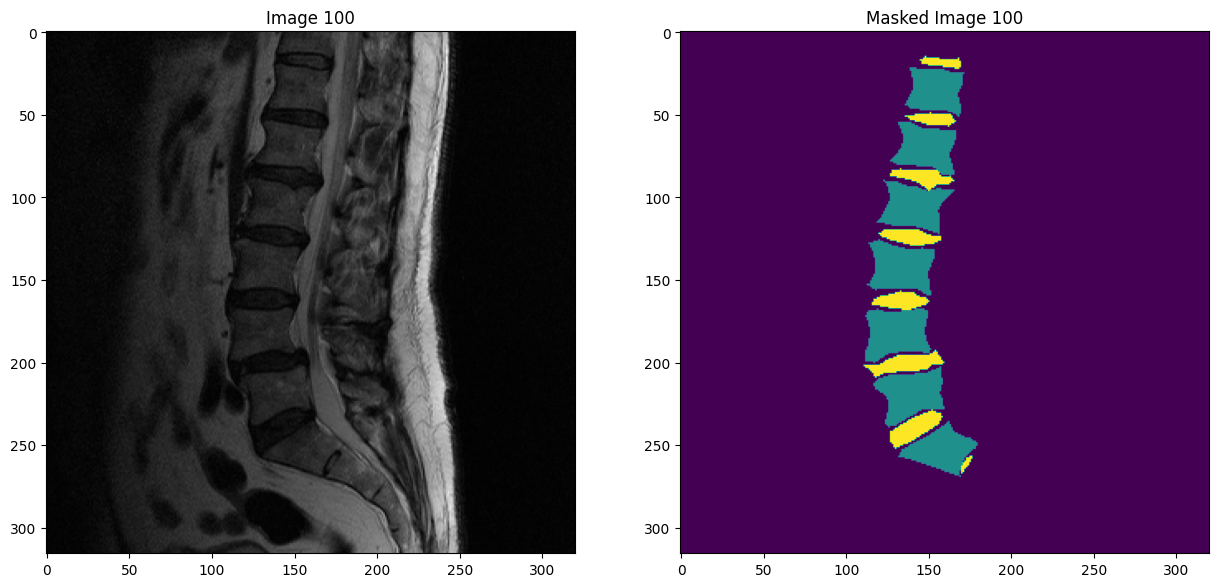

In [ ]:
# Drawing images and masks
start_img = 100 #
stop_img = 101
for i in range(start_img, stop_img):
    img_view  = Image.open(unmaskedPath + img[i]).convert('RGB') # путь к изображению
    mask_view = Image.open(maskedPath + mask[i]) # путь к его маске

    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view) # рисуем изображение
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view) # рисуем маску
    arr[1].set_title('Masked Image '+ str(i))

Text(0.5, 1.0, 'Processed Masked Image ')

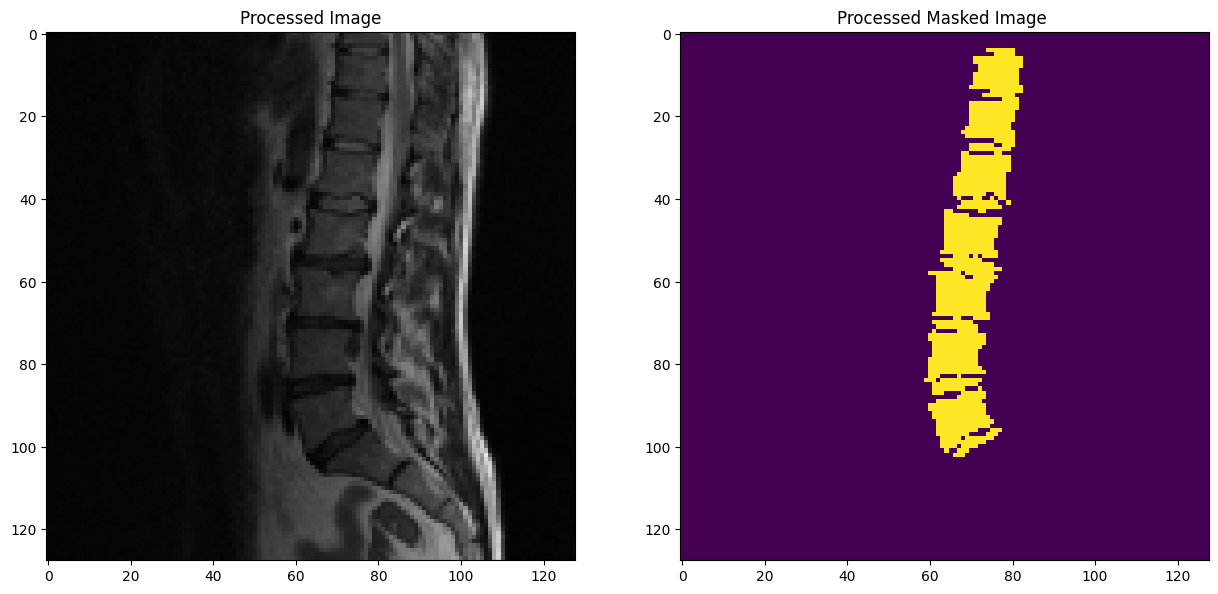

In [ ]:
target_shape_img = [128, 128, 3] # размер изображений
target_shape_mask = [128, 128, 1] # размер масок

# обрабатываем
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, unmaskedPath, maskedPath)

# отображаем обработанные изображения и маски
image_index = 157
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

Разделяем данные на обучающие 80% и проверочные 20% случайно.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

Создаем сеть, 3 класса, 32 базовых каналов.

In [ ]:
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [ ]:
# looking at the net
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

Задаем параметры обучения и обучаем сеть.

In [ ]:
# оптимизатор Adam, функция ошибки - кроссэнтропия которая применяет softmax к выходам сети, метрика - аккуратность
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Обучаем ~ 10 минут (увеличьте число эпох)
results = unet.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_valid, y_valid))

Epoch 1/40
8/8 [==============================] - 183s 23s/step - loss: 0.1386 - accuracy: 0.9304 - val_loss: 0.1348 - val_accuracy: 0.9318
Epoch 2/40
8/8 [==============================] - 174s 22s/step - loss: 0.1379 - accuracy: 0.9313 - val_loss: 0.1538 - val_accuracy: 0.9386
Epoch 3/40
8/8 [==============================] - 173s 22s/step - loss: 0.1554 - accuracy: 0.9379 - val_loss: 0.1345 - val_accuracy: 0.9411
Epoch 4/40
8/8 [==============================] - 171s 21s/step - loss: 0.1373 - accuracy: 0.9417 - val_loss: 0.1302 - val_accuracy: 0.9477
Epoch 5/40
8/8 [==============================] - 176s 22s/step - loss: 0.1288 - accuracy: 0.9487 - val_loss: 0.1195 - val_accuracy: 0.9535
Epoch 6/40
8/8 [==============================] - 166s 21s/step - loss: 0.1204 - accuracy: 0.9506 - val_loss: 0.1295 - val_accuracy: 0.9508
Epoch 7/40
8/8 [==============================] - 165s 21s/step - loss: 0.1167 - accuracy: 0.9529 - val_loss: 0.1090 - val_accuracy: 0.9568
Epoch 8/40
8/8 [====

### Проверяем работу модели

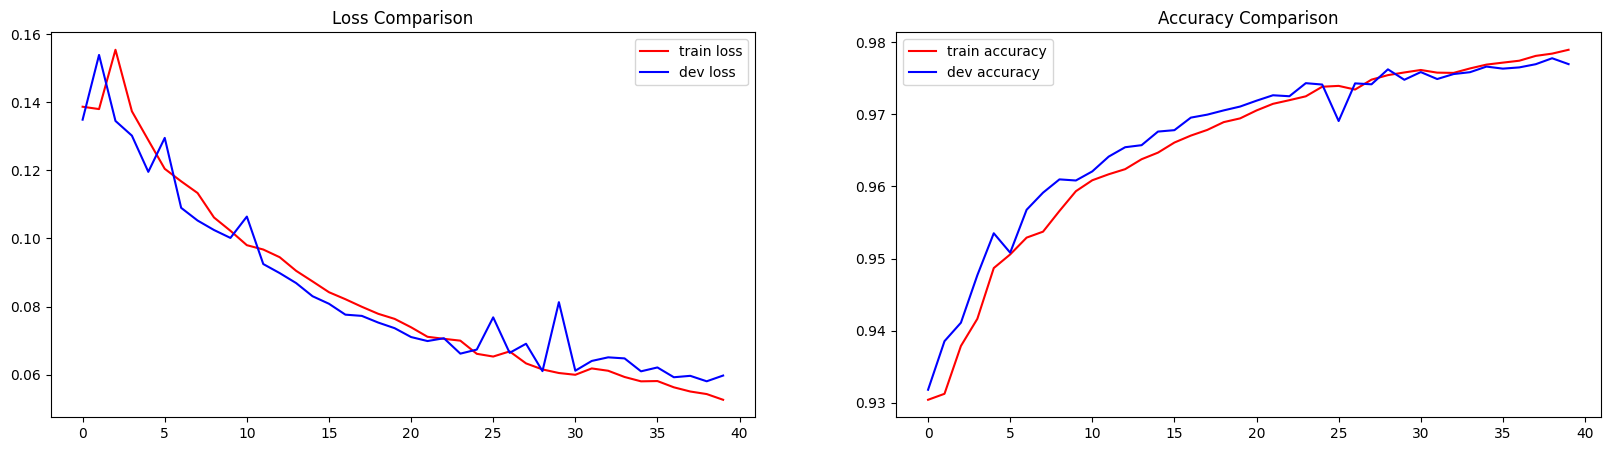

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

In [ ]:
# оценка качества сети
unet.evaluate(X_valid, y_valid)

2/2 [==============================] - 10s 5s/step - loss: 0.0597 - accuracy: 0.9770


[0.05974198877811432, 0.9769623875617981]

In [ ]:
# рисуем
def VisualizeResults(index):
    img = X_valid[index] # изображение
    img = img[np.newaxis, ...] # добавляем измерение примеров
    pred_y = unet.predict(img) # расчитываем маску
    pred_mask = tf.argmax(pred_y[0], axis=-1) # выбираем максимальный класс (канал - последнее измерение)
    pred_mask = pred_mask[..., tf.newaxis] # канальное измерение добавляем
    # рисуем
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

In [ ]:
# рисуем
index = 40
VisualizeResults(index)

In [ ]:
# Saving the model
unet.save('/content/drive/MyDrive/Colab Notebooks/Spinal/success_model.keras')